# Prompt engineering

In [2]:
import re
import string
import numpy as np
from math import pi
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

# import other python files
from utils_benchmark import *
from utils import *
from elaboration import *
from similarity import *
from flexibility import *
from process_humans_data import *

In [3]:
%load_ext autoreload
%autoreload 2

## Load data

In [9]:
humans = pd.read_csv('./data_processed/humans_data_processed.csv')

#todo
gpt_35_processed_prompt_1 = pd.read_csv('./data_processed/prompt_1/gpt35_merged_343.csv')
gpt_4_processed_prompt_1  = pd.read_csv('./data_processed/prompt_1/gpt4_merged_398.csv')

gpt_35_processed_prompt_2 = pd.read_csv('./data_processed/prompt_2/gpt35_merged_329.csv')
gpt_4_processed_prompt_2  = pd.read_csv('./data_processed/prompt_2/gpt4_merged_372.csv')

In [10]:
# normalize 
combined_data = pd.concat([
    humans.assign(dataset='Humans'),
    gpt_35_processed_prompt_1.assign(dataset='GPT-3.5 prompt 1'),
    gpt_35_processed_prompt_2.assign(dataset='GPT-3.5 prompt 2'),
    gpt_4_processed_prompt_1.assign(dataset='GPT-4 prompt 1'),
    gpt_4_processed_prompt_2.assign(dataset='GPT-4 prompt 2')
])

combined_data_norm = normalization_1(combined_data, check_norm = False)

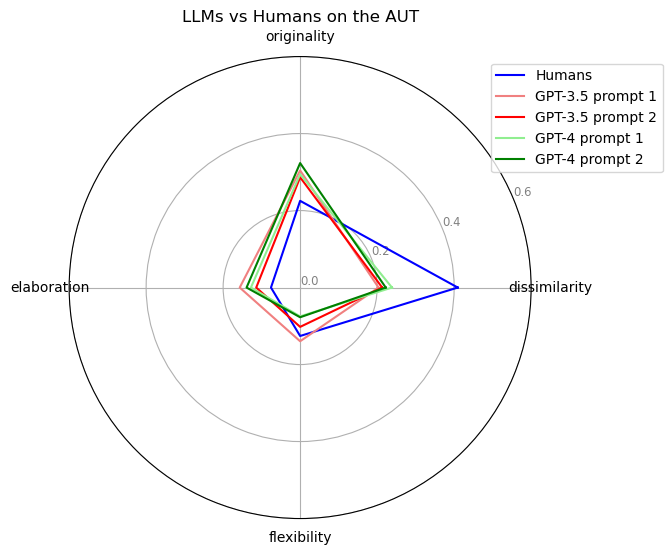

In [11]:
features = ['prompt', 'dissimilarity', 'originality', 'elaboration', 'flexibility']

humans_norm = combined_data_norm[combined_data_norm['dataset'] == 'Humans']
gpt_35_norm_p1 = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5 prompt 1']
gpt_4_norm_p1 = combined_data_norm[combined_data_norm['dataset'] == 'GPT-4 prompt 1']
gpt_35_norm_p2 = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5 prompt 2']
gpt_4_norm_p2 = combined_data_norm[combined_data_norm['dataset'] == 'GPT-4 prompt 2']

# List of dataframes and corresponding titles
dataframes = [humans_norm[features], gpt_35_norm_p1[features], gpt_35_norm_p2[features], gpt_4_norm_p1[features], gpt_4_norm_p2[features]]
titles = ['Humans', 'GPT-3.5 prompt 1', 'GPT-3.5 prompt 2', 'GPT-4 prompt 1', 'GPT-4 prompt 2']
colors = ['blue', 'lightcoral', 'red', 'lightgreen', 'green']

# Plot radar chart for multiple dataframes
plot_radar_chart(dataframes, titles, colors, avg_per_object = True)

### Radar charts per object

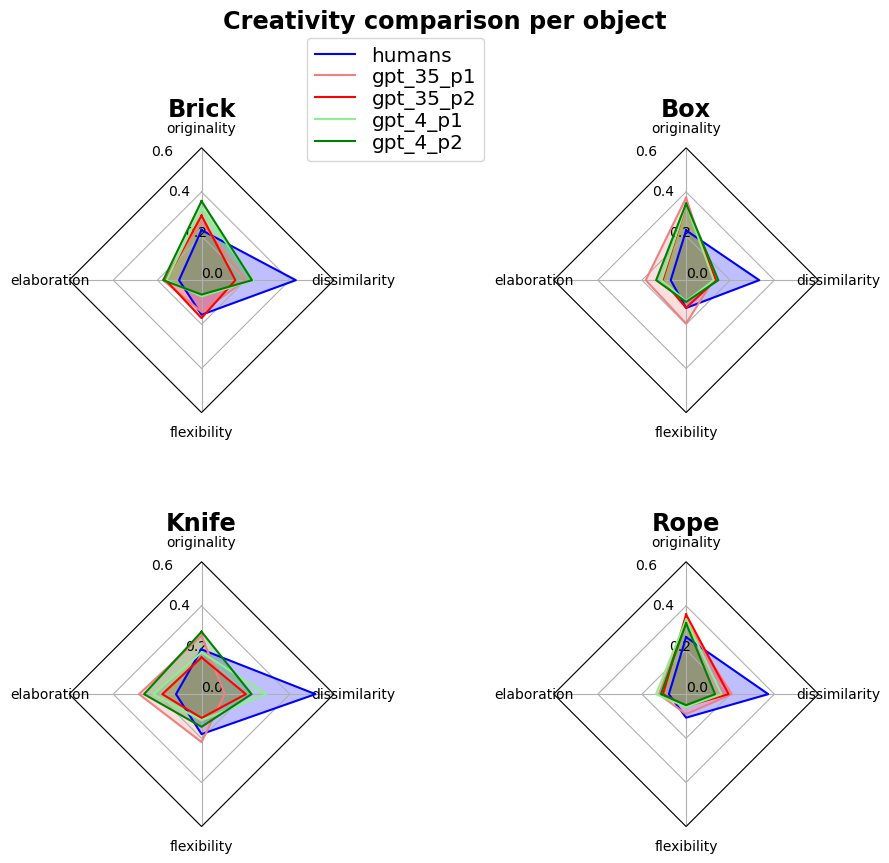

In [12]:
### PARAMETERS ###
data_dict = {"humans": humans, "gpt_35_p1": gpt_35_processed_prompt_1, "gpt_35_p2": gpt_35_processed_prompt_2, "gpt_4_p1": gpt_4_processed_prompt_1, "gpt_4_p2": gpt_4_processed_prompt_2}
features = ["originality", "elaboration", "flexibility", "dissimilarity"]
#################

objects = ["brick", "box", "knife", "rope"]
normalized_data = prepare_data_for_radar_chart_per_object(data_dict, objects)
brick_norm, box_norm, knife_norm, rope_norm = normalized_data["brick_norm"], normalized_data["box_norm"], normalized_data["knife_norm"], normalized_data["rope_norm"]
dataframes = [brick_norm, box_norm, knife_norm, rope_norm]
colors = ['blue', 'lightcoral', 'red', 'lightgreen', 'green']
titles = data_dict.keys()

radar_charts_per_object(brick_norm, box_norm, knife_norm, rope_norm, features, model_names = list(data_dict.keys()), colors = colors)

### Univariate analysis

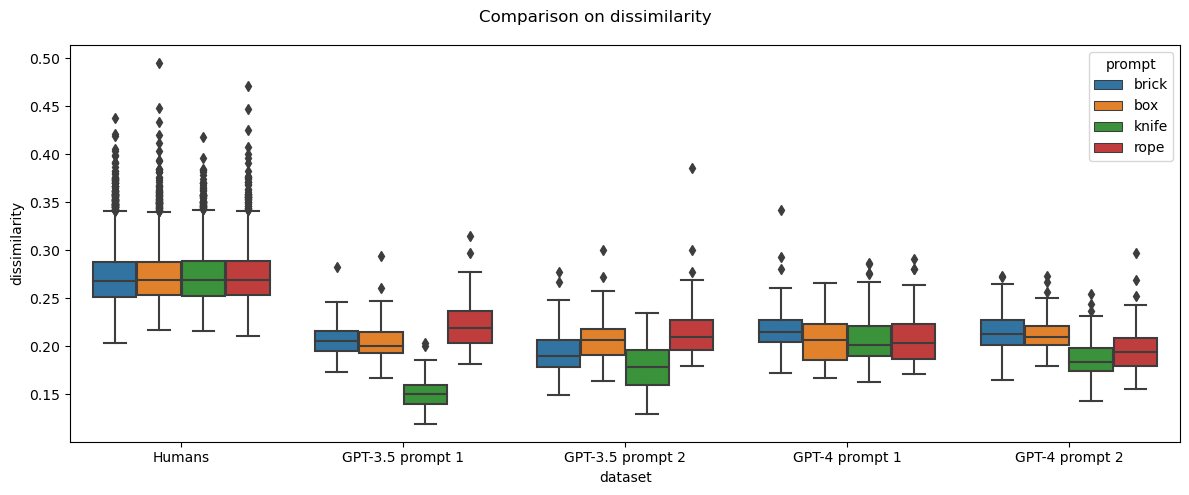

In [18]:
plot_per_object(type = "boxplot", data_dict = data_dict, features = ["dissimilarity"], combined_data_norm_per_object = combined_data)